In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Exploratory analysis for SMEs in HCMC"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

AIM: 
- explore data to refine questions about data
- search for answers by visual comparisons and transformations


In [2]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mplleaflet as mpl

sys.path.insert(0, "../")
import utils.utils_figures as f

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<Figure size 2000x1000 with 0 Axes>

In [3]:
# load cleaned survey data


df_candidates = pd.read_excel("../input_survey_data/input_data_business.xlsx") 
df_all = pd.read_excel("../input_survey_data/input_data_business_ex.xlsx") 


df_all['geometry'] = df_all['geometry'].apply(wkt.loads)

df_all = gpd.GeoDataFrame(df_all, crs='epsg:4326')
## workaround: fix flip of coordinates to lon, lat
df_all = gpd.GeoDataFrame(df_all, 
        geometry=gpd.points_from_xy(df_all.geometry.x, df_all.geometry.y)#.split(",")[0], df_candidates.GPS.split(",")[1])
)

print(df_all.crs)
df_all.head(5)

epsg:4326


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,contaminations_visible,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,flood_year,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,geometry,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,id,shp_building_value_euro,shp_content_value_euro,shp_registered_capital_euro,elevation_m
0,0.0,0.0,2.0,10.0,1,0,0,0,0,2,3.0,0,0,0,0,0,0,0,1,1,1,5,5,5,4,5,5,5,5,2015.0,80.0,1,12.0,25.0,POINT (106.69897 10.79648),2.0,3,17,1,2,1,1,0,0,0,0,4.0,1.0,1.0,5.0,2.0,5.0,5.0,1.0,2,5.0,2.0,1.0,3.0,3.0,3.0,0.0,1841.3,1841.3,184.1,1.72359
1,0.0,0.0,2.0,15.0,0,1,0,0,0,2,NaN,0,0,0,0,0,0,0,1,1,0,5,5,5,4,5,5,5,5,2017.0,70.0,1,0.0,21.0,POINT (106.69891 10.79652),3.0,3,22,1,2,1,0,1,0,0,0,4.0,1.0,1.0,5.0,1.0,5.0,5.0,1.0,1,5.0,2.0,3.0,1.0,1.0,NaN,1.0,1841.3,1841.3,368.3,1.18550
2,0.0,0.0,1.0,2.0,1,0,0,0,0,2,NaN,0,0,0,0,0,0,0,1,1,1,1,5,1,1,5,1,5,5,2020.0,50.0,1,21.0,50.0,POINT (106.70081 10.79754),4.0,1,31,1,1,1,1,0,0,0,0,3.0,1.0,1.0,4.0,1.0,2.0,4.0,2.0,4,4.0,2.0,3.0,1.0,3.0,3.0,2.0,16571.5,16571.5,368.3,1.66465
3,0.0,NaN,3.0,10.0,1,0,0,0,0,1,8.0,0,0,0,0,0,0,0,1,1,1,1,1,5,5,5,1,5,3,2020.0,NaN,1,20.0,25.0,POINT (106.70107 10.79757),2.0,1,11,1,1,1,1,0,0,0,0,3.0,1.0,1.0,5.0,4.0,1.0,5.0,1.0,5,5.0,1.0,2.0,3.0,3.0,2.0,3.0,7365.1,7365.1,NaN,1.49934
4,0.0,0.0,3.0,5.0,0,1,0,0,1,3,NaN,0,0,0,0,0,0,0,1,1,0,5,5,5,1,5,1,5,3,2020.0,10.0,1,20.0,80.0,POINT (106.70010 10.79742),3.0,1,11,1,1,1,1,0,0,0,0,2.0,1.0,1.0,5.0,3.0,1.0,5.0,2.0,5,5.0,1.0,2.0,3.0,3.0,2.0,4.0,16571.5,16571.5,36.8,1.65202


In [4]:
df_candidates_y = df_candidates[["Target_contentloss_euro", "Target_businessreduction"]]
df_candidates_X = df_candidates.drop(["Target_contentloss_euro", "Target_businessreduction"], axis=1)



## Exploratory data analysis


### Map spatial distribution of interviewed businesses
Explore interactively selection of important predictors and targets 

In [5]:
#sm = df_candidates[["Target_contentloss_euro", "Target_businessreduction", "inundation_duration_h", "water_depth_cm", "geometry"]]
sm = df_all[["Target_contentloss_euro", "Target_businessreduction", "inundation_duration_h", "water_depth_cm", "geometry"]]
sm = sm[~ sm.is_empty]   # drop emtpy geoms
sm.explore("water_depth_cm", cmap="cool")

In [6]:
## see statistical dstribution
df_candidates.describe()


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
count,386.000000,361.000000,388.000000,396.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,89.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,334.000000,397.000000,370.000000,395.000000,373.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,382.000000,369.000000,379.000000,382.000000,382.000000,379.000000,374.000000,343.000000,397.000000,386.000000,369.000000,241.000000,245.000000,261.000000,371.000000,335.000000,350.000000,393.000000
mean,945.630829,18.465374,13.312371,34.335859,0.090680,0.891688,0.068010,0.025189,0.564232,3.027708,6.758427,0.413098,0.408060,0.680101,0.516373,0.327456,0.367758,0.040302,0.123426,0.896725,2.894207,3.219144,3.521411,2.775819,4.821159,3.962217,4.919395,4.695214,71.751497,0.599496,19.735135,89.102532,3.348525,3.801008,19.498741,1.937028,1.947103,0.856423,0.607053,0.607053,0.052897,0.010076,0.005038,2.808901,2.466125,2.575198,2.986911,3.803665,2.010554,2.828877,2.131195,4.657431,2.945596,2.319783,2.269710,1.820408,2.298851,2.385445,16544.596716,5365.970857,1.465553
std,11616.088512,25.227730,42.147994,25.918095,0.287516,0.311167,0.252081,0.156896,0.496483,1.269987,12.590606,0.493011,0.492095,0.467026,0.500362,0.469877,0.482804,0.196915,0.329340,0.304701,1.930325,1.890924,1.871549,1.650718,0.735641,1.666995,0.549151,1.257423,38.907775,0.490619,14.002520,97.899512,1.073498,12.128446,15.675469,2.039648,0.937288,0.351103,0.489022,0.489022,0.224110,0.099996,0.070888,0.909342,1.404405,1.258418,1.420634,1.316436,1.225779,1.263053,1.190970,0.687938,1.220876,0.947344,0.934231,0.962617,0.950080,0.619244,18057.524857,38688.618337,0.412253
min,0.000000,0.000000,0.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000,12.000000,1.000000,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1104.800000,36.800000,-0.069113
25%,0.000000,0.000000,2.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00

In [7]:

# fig, ax_hist = plt.subplots(len(df_targets.columns), 1, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})

# #for i, c in enumerate(df_targets.columns[:]):
#     #plt.subplots_adjust(hspace=.2)
# #sns.boxplot(x=df_targets.astype(float), showfliers=True, ax=ax_hist[0]).set(title=f"", xlabel=None)
# sns.histplot(x=df_targets.astype(float), stat='count', ax=ax_hist[1]).set(title=" ", xlabel=None) # bins=12, stat="percent"


In [8]:
#df_candidates.shp_registered_capital_mVND[df_candidates.Target_contentloss_euro!=0.0].describe()

# content loss for HCMC 137euro (mean:2242) when all non-damages are removed
# shp_registered_capital_mVND

### count 0 and missing values for each predictor

In [9]:
df_candidates.isna().sum().sort_values()[-13:]# count also np.nan


perception_private_economy_future               26
bage                                            27
shp_risk_tolerance                              28
perception_who_responsible4protection.Rank1     28
Target_businessreduction                        36
shp_registered_capital_euro                     47
resilience_govern_careing_increases             54
shp_content_value_euro                          62
elevation_building_height_cm                    63
perception_govern_support_future               136
perception_govern_support_past                 152
perception_who_responsible4protection.Rank2    156
warning_time_h                                 308
dtype: int64

In [10]:
## count zeros
df_candidates[df_candidates==0].count().sort_values()[-10:]


emergency_measures.7        251
emergency_measures.6        267
emergency_measures.9        348
contaminations.0            361
contaminations.2            370
shp_suppliers_location.3    376
emergency_measures.8        381
contaminations.3            387
shp_suppliers_location.4    393
shp_suppliers_location.5    395
dtype: int64

In [11]:
## drop columns with too many missing information
# df_sm = df_candidates.drop(df_candidates.filter(regex="^warning_type*|perception_who_responsible4protection.Rank1|perception_who_responsible4protection.Rank2|perception_who_responsible4protection.Rank5|perception_who_responsible4protection.Rank6|perception_who_responsible4protection.Rank7|perception_who_responsible4protection.Rank88"), axis=1)


Many shops reported no direct losses as well as no indirect losses expressed as business reudction. While missing information about the direct and indirect losses is seldom

## Correlation

#### TODO modify to Spearman's rho

Visualize monotonic relatonhips between variables and targets as well betwene the predictors itself using Spearman's rank coefficient

In [12]:
#df_sm_corr.shp_closed_d.describe(
#df_sm.filter(regex="2",axis=1)#[df_sm_corr.shp_closed_d==0.0]#.sum()  # 78, 222, 231=shp_closed_d

df_candidates

KeyboardInterrupt: 

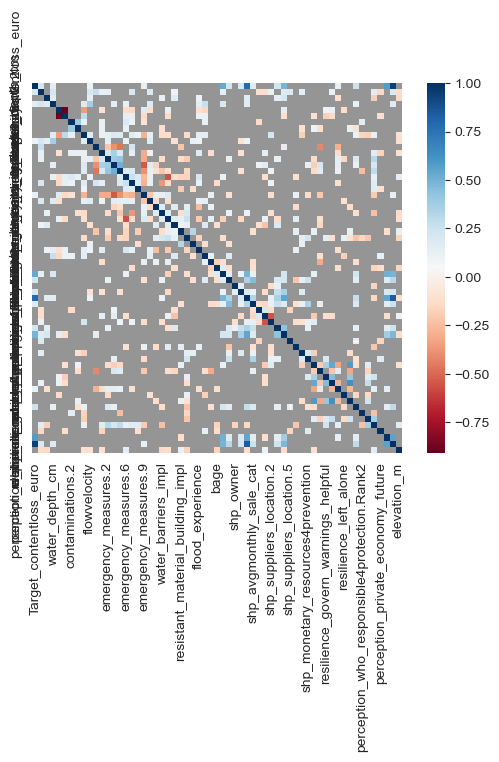

In [ ]:
## get the p value for pearson coefficient, subtract 1 on the diagonal
pvals = df_candidates.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_candidates.corr().shape)
psig = 0.05  # 5% signif level

#  main plot
sns.heatmap(df_candidates.corr(), annot=False, square=True, cmap="RdBu", fmt=".2f", zorder=1)

# signifcance mask
#if signif == True:
## add another heatmap with colouring the non-significant cells
sns.heatmap(df_candidates.corr()[pvals>=psig], annot=False, square=True, cbar=False, 

## add-ons
cmap=sns.color_palette("Greys", n_colors=1, desat=1),  zorder = 2) #put the map above the heatmap
## add a label for the colour
colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
texts = [f"not significant (at {psig})"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')


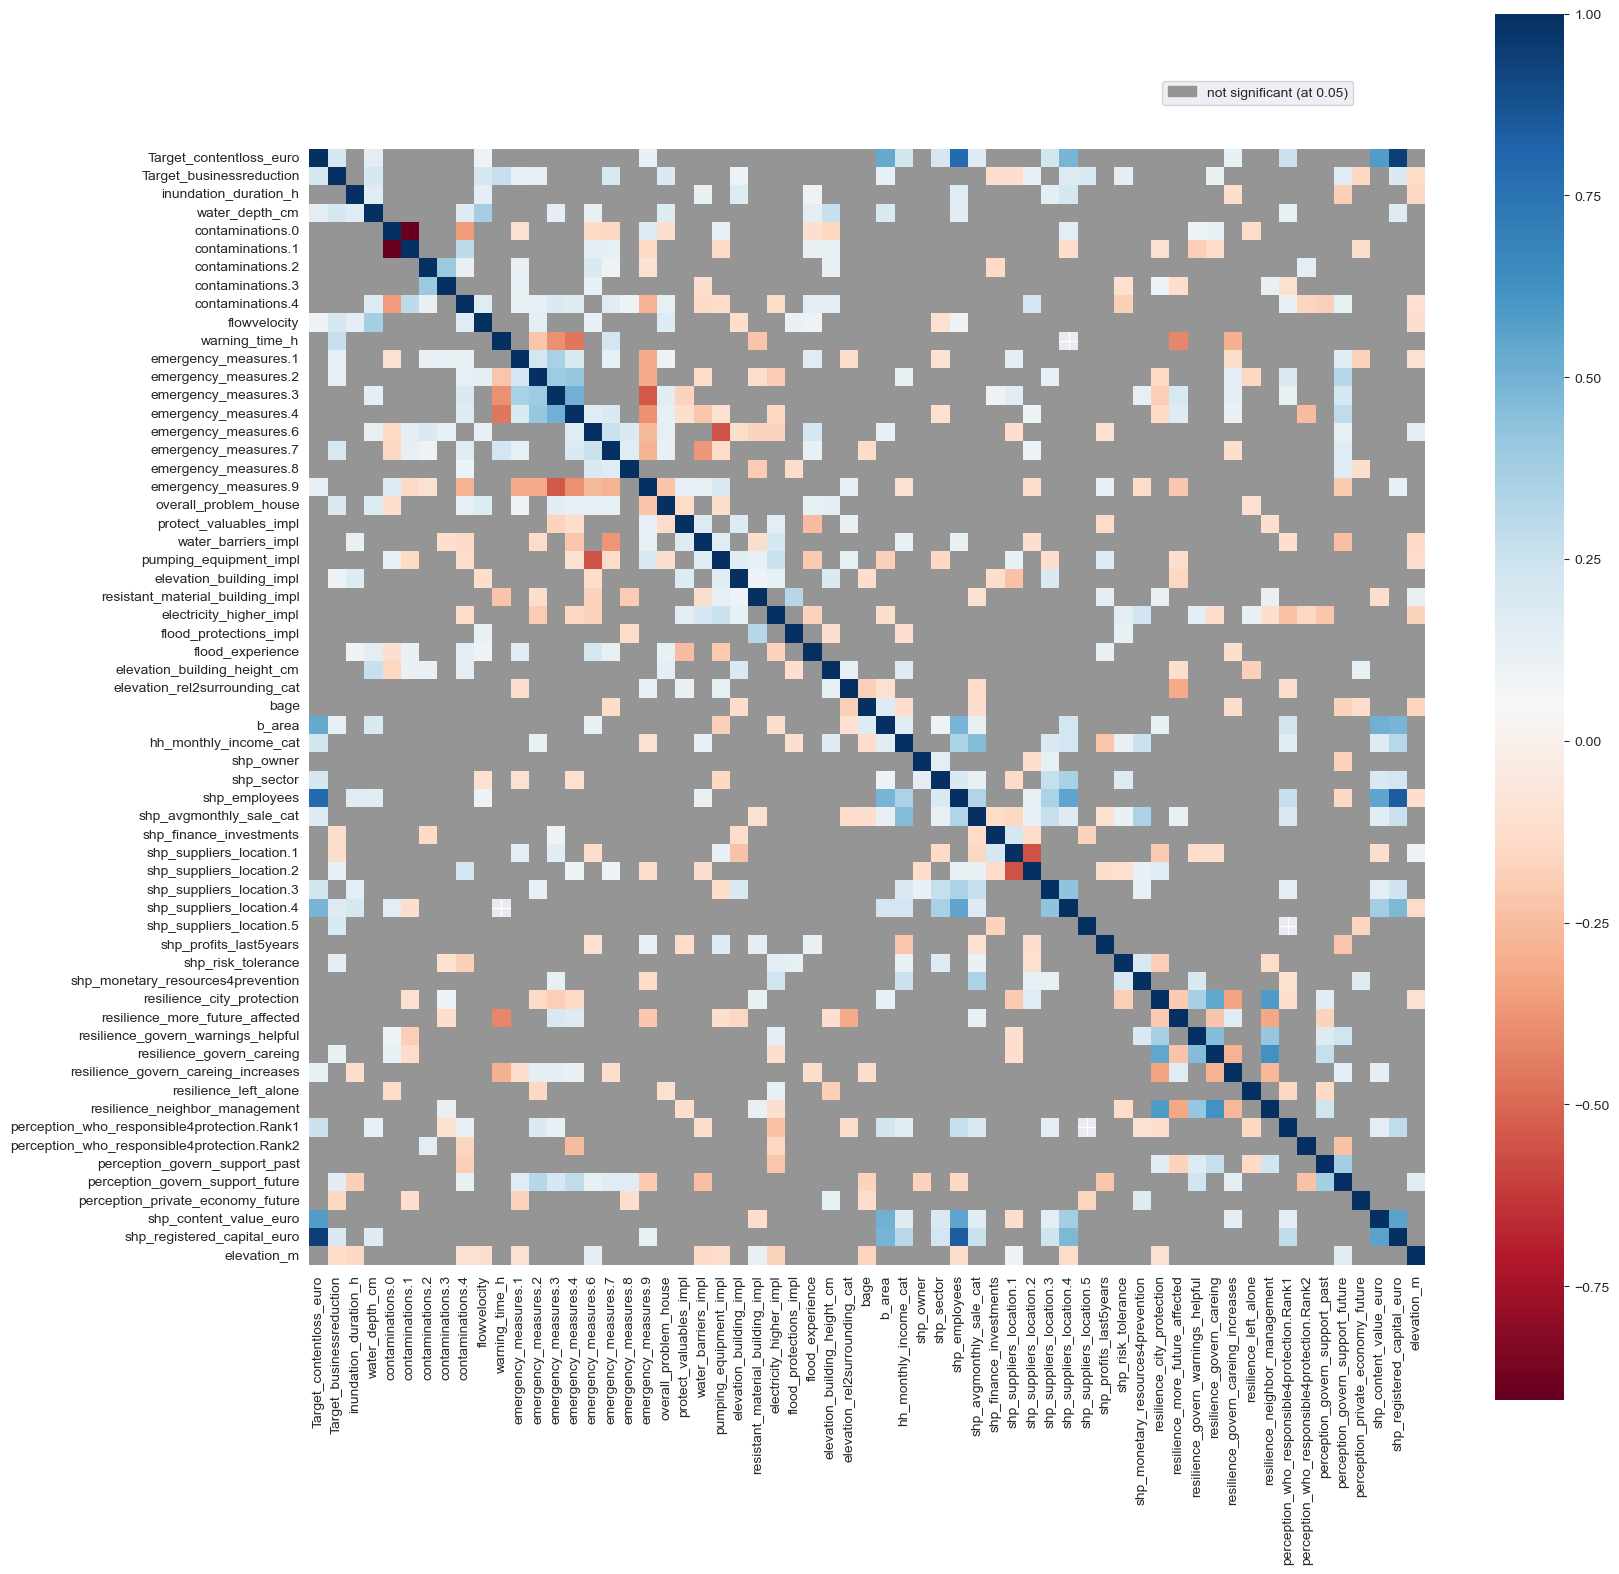

In [14]:
# df_sm = df_candidates

#df_sm= df_sm.replace(" ", np.nan)
#df_sm_corr = df_sm_corr.replace(np.nan, 0)
 

plt.figure(figsize=(18,18))
f.plot_pearsoncorrelation(df_candidates, signif=True, psig=0.5)

#### Summarize Correlation Coefs
--> many predictors have not a signicant relationship to the target,- but this is only for linear relationships
--> high corr (>0.8) between targets ~ [shp_closed_d, shp_duration_back2normal, shp_emplees, shp_capital_mVND]
--> Low corr coeffs between targets, for 
    emergency_measures, 
    private precautions in VND (eg. water-barriers, water-resistant material) - TODO check for implementations
    building_elevation_rel2surrounding
    warning_time_h
    building_floor
    shp_risk_behaviour
    shp_monetary_resources_prenvention
    --> replace them or combine them with PCA

--> TODO examine shp_damage_level_products low correlation to targets - why?

In [14]:
## Drop predictors with too many missing inforamtion and non linear correlation to targets

# Warning time  (nan = 308) as well as perception of the government support in the future (nan = 136) are kept in the predictors set 
# due to their correaltion with on of the targets. 


# df_candidates = df_candidates.drop(["perception_govern_support_past", "perception_who_responsible4protection.Rank2"], axis=1)
# df_candidates.to_excel("../input_survey_data/input_data_business_2.xlsx", index=False)
# # perception_govern_support_past nan = 152
# # perception_who_responsible4protection.Rank2    156


#### quantify mulitcollinearity


In [15]:
df_candidates.filter(regex="_impl", axis=1)

,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl
0,5,5,5,4,5,5,5
1,5,5,5,4,5,5,5
2,1,5,1,1,5,1,5
3,1,1,5,5,5,1,5
4,5,5,5,1,5,1,5
...,...,...,...,...,...,...,...
392,1,1,5,4,5,5,5
393,2,1,1,2,5,1,5
394,1,1,1,4,5,5,5
395,1,5,1,1,5,5,5


In [16]:
df_candidates.flood_protections_impl[df_candidates.flood_protections_impl==5].count()

388

In [17]:
df_vif = pd.DataFrame()
df_vif["features"] = df_candidates_X.columns
df_candidates_X_filled = df_candidates_X.replace(np.nan, 0)
df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
df_vif.sort_values("vif_scores", ascending=False)  

print("averaged VIF score is around: ", round(df_vif.vif_scores.mean(),1))
print(df_vif.sort_values("vif_scores", ascending=False)  )
# VIF >5 : high correlation
# VIF 1-10: medium correlation


averaged VIF score is around:  10.8
                                       features  vif_scores
24                       flood_protections_impl   99.082965
22             resistant_material_building_impl   80.092406
3                              contaminations.1   63.509282
49                        resilience_left_alone   52.933415
25                             flood_experience   20.562854
58                                  elevation_m   18.296417
50               resilience_neighbor_management   13.195487
17                        overall_problem_house   12.176515
55            perception_private_economy_future   11.690421
23                      electricity_higher_impl   11.497777
30                        hh_monthly_income_cat   10.839017
7                                  flowvelocity   10.655558
41                       shp_profits_last5years   10.653912
45              resilience_more_future_affected   10.369755
34                      shp_avgmonthly_sale_cat   10.202711
47  

##### Summarize VIF scores
--> Pearson Corr Coeff shows bivariate correlation between one var ~ to another var
--> VIF shows Correlation between one var ~ group of other vars

--> precaution measures and shop size  (i.e. nmbr employees,registed capital )will probably inlfucnence the model predictions of damage costs.
--> multicollineary can decrease ML learning (matters only for Regressions). For RF it limits interpretability of used features, i.e. less expressive feature importance, due to redundancy of features  (esp. if only few trees were used) 

--> apply PCA to reduce dimensionality and to solve mulitcollinearity of some predictors (esp. for shp_closed_d, shp_duration_back2normal, shp_capital_mVND, shp_employees,	business_reduction_s, contaminations, shp_avgmonthly_sale_mVND business_reduction_r) or alternatively remove redundant variables , alternativly apply feature selection by e.g. Random Forests "feature importance"


In [18]:
print( "Amount of missing vlaues or zeros per column in % to total number of data points.")
print("Note: Some are overestimated due that for some predictors zero means 'no' e.g. no monthly sale reduction (business_reduction) or no financal support for elevated building\n")
print("Percentage of businesses without content losses or without business reduction")
print(round(df_candidates_y[df_candidates_y == 0].count() / len(df_candidates_y) *100, 1))

## *_impl: did not implement precuation= 5

Amount of missing vlaues or zeros per column in % to total number of data points.
Note: Some are overestimated due that for some predictors zero means 'no' e.g. no monthly sale reduction (business_reduction) or no financal support for elevated building

Percentage of businesses without content losses or without business reduction
Target_contentloss_euro     56.9
Target_businessreduction    37.5
dtype: float64


### Overview: flood events, total costs of damages, business reduction, flood variables 

- select years of flood events
- compare occurence of floods with total direct costs for damages on business contents 


Text(0.5, 1.0, 'monthly reduction due to flooding')

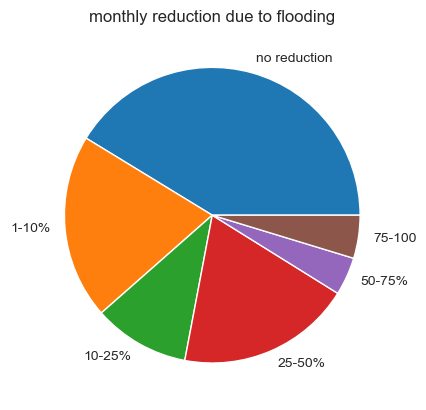

In [19]:
## visualize distribution for most importnat variable = business_reduction 

business_reduction_classes = df_candidates.Target_businessreduction.groupby(pd.cut(
    df_candidates.Target_businessreduction,  [-0.01, 0.01, 10.0, 25.0, 50.0, 75.0, 100.0],)
    #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
    ).count()
business_reduction_classes = pd.DataFrame(business_reduction_classes)

#def pie_plot(df_column, x=df.columns() , labels=df):
plt.pie(x=business_reduction_classes.Target_businessreduction, labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], data=business_reduction_classes)
#plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
plt.title("monthly reduction due to flooding")

In [20]:
# ## Timeline: flood events

# floods_years_rs = pd.DataFrame({"most_serious": df_all["flood_year_s"].value_counts(),
#        "most_recent": df_all["flood_year_r"].value_counts()})
# floods_years_rs.index.name = "years"


# fig, ax = plt.subplots(1,2, figsize=(10,5))

# floods_years_rs.most_serious.plot.bar( ax=ax[0], title="most serious flood events")
# floods_years_rs.most_recent.plot.bar( ax=ax[1], title="most recent flood events")
# ax[0].set_ylabel("count")
# ax[1].set_ylabel("count")


In [21]:
# sum(rfloods_by_year.loc["2018",:].sum())

In [22]:
# ## Timeline: Damage costs caused by floods

# ## TODO check if cost by year are correct - eg. Leitpold "total costs per secotr" - seems erroneous eg. 2011, 2019 with many flood events

# df = df.sort_values('flood_time_r')
# rfloods_by_year = df.groupby('flood_time_r')['Target_direct_r']
# rfloods_by_year = pd.DataFrame(rfloods_by_year.apply(list).values).set_index(pd.DataFrame(rfloods_by_year)[0])
# df = df.sort_values('flood_time_s')
# sfloods_by_year = df.groupby('flood_time_s')['Target_direct_s']
# sfloods_by_year = pd.DataFrame(sfloods_by_year.apply(list).values).set_index(pd.DataFrame(sfloods_by_year)[0])


# fig, ax = plt.subplots(1,2, figsize=(10,5))
# sfloods_by_year[0].apply(sum).plot.bar( title="total direct loss to business content \nfor most serious flood events", ax=ax[0]) # .astype("Int64")
# rfloods_by_year[0].apply(sum).plot.bar( title="total direct loss to business content \nfor most recent flood events", ax=ax[1])
# ax[0].set_ylabel("mVND")
# ax[0].set_xlabel("")
# ax[1].set_xlabel("")
# ax[0].set_ylim([0,1000]) 
# ax[0].set_ylabel(f"mVND, max= {sum(sfloods_by_year.loc['2019',:].sum())} mVND")
# ax[1].set_ylim([0,1000])  #ax[1].set_yscale('log')
# ax[1].set_ylabel(f"mVND, max= {sum(rfloods_by_year.loc['2018',:].sum())} mVND")


Text(0, 0.5, 'count')

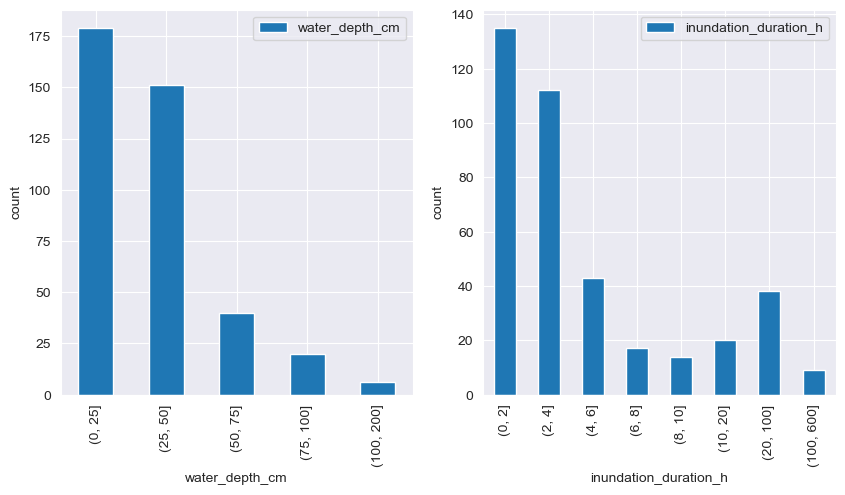

In [23]:
## Timeline: flood variables forflood events

# categorize continious flood variables
inundation_duration_classes = df_candidates.inundation_duration_h.groupby(pd.cut(df_candidates.inundation_duration_h, [0, 2, 4, 6, 8, 10, 20, 100, 600])).count()
water_depth_classes = df_candidates.water_depth_cm.groupby(pd.cut(df_candidates.water_depth_cm, [0, 25, 50, 75, 100, 200])).count()
inundation_duration_classes = pd.DataFrame(inundation_duration_classes)
water_depth_classes = pd.DataFrame(water_depth_classes)

fig, ax = plt.subplots(1,2, figsize=(10,5))
water_depth_classes.plot.bar( ax=ax[0])
inundation_duration_classes.plot.bar( ax=ax[1])
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")

#### Summarize water depth and inundation duration

- both flood variables have not a gaussian distribution -> normaization is more suitable when uni- and bivariate stage-damage functions are applied by using the m as independend variables.

#### shp_damage_level_products_ + equipemtn + funiture

In [24]:
# #df_candidates_combined.shp_damage_level_products.value_counts(
# df_candidates_combined.filter(regex="shp_damage_level")

In [25]:
# df_candidates_combined.shp_damage_level_products.value_counts()
# #.filter(regex="shp_damage_level")
# # ## visualize distribution for most importnat variable = business_reduction 

# business_reduction_classes = df_candidates_combined.shp_damage_level_products.groupby(pd.cut(
#     df_candidates_combined.shp_damage_level_products, #list(df_candidates_combined.shp_damage_level_products.unique()+0.1))
#     [0.0, 1.0, 2.0, 3.0, 4.0, 99.0],)
#     #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
#     ).count()
# business_reduction_classes = pd.DataFrame(business_reduction_classes)

# plt.pie(x="shp_damage_level_products", data=business_reduction_classes, labels=list(df_candidates_combined.shp_damage_level_products.unique()))
# #plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
# plt.title("damage levels to products")

In [26]:
# business_reduction_classes = df_candidates_combined.shp_damage_level_equipment.groupby(pd.cut(
#     df_candidates_combined.shp_damage_level_equipment, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)
#     #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
#     ).count()
# business_reduction_classes = pd.DataFrame(business_reduction_classes)

# plt.pie(x="shp_damage_level_equipment", labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], data=business_reduction_classes)
# #plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
# plt.title("damage levels to business buildings")

## Variable distribution
- types of businesses = DONE
- water depth and inundation duration = DONE
- educational level
- distribution and amount of obs for business disruptions [monthly reduction %] P1Q5.9
- target 1 : direct costs of losses for business contents [VND] DONE 


In [27]:
# ## Glimpse: distribtion
# %matplotlib inline  


# df_candidates.Target_contentloss_euro[df_candidates.Target_contentloss_euro > 0.0].hist(bins=200, figsize=(20,15))
# #df_candidates.Target_businessreduction.hist(bins=50, figsize=(20,15))
# plt.ylim(0,10)
# plt.show()

In [40]:
features_continous = df_all[[
    "inundation_duration_h", "water_depth_cm", "flowvelocity", "warning_time_h",
    "elevation_building_height_cm", "bage", "b_area", "shp_employees", 
    "shp_building_value_euro", "shp_content_value_euro", "shp_registered_capital_euro", 
    "elevation_m"
    ]]

In [46]:

df_all[col].max()

2.53386

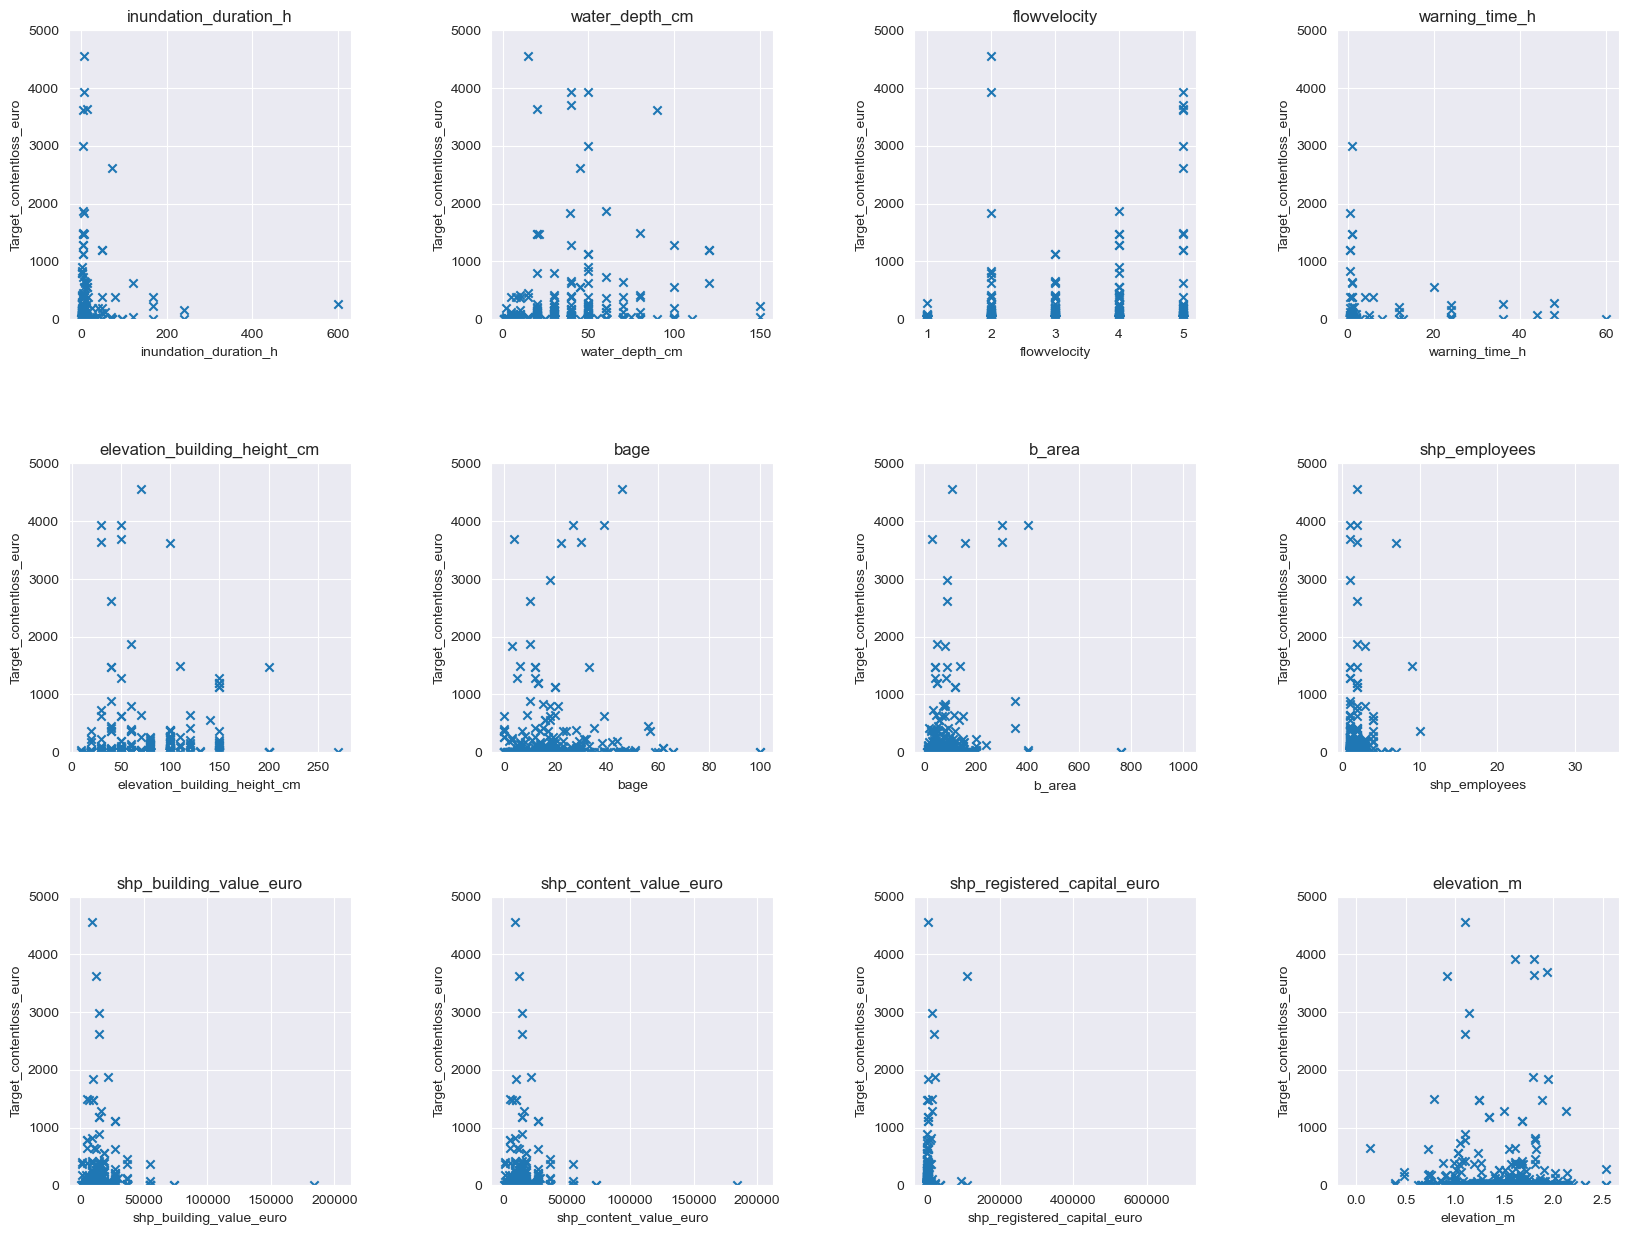

In [49]:
# plot correlations between feature and target
plt.figure(figsize=(20, 15))

target = df_candidates_y.iloc[:,0]

for i, col in enumerate(features_continous):
    plt.subplot(3, 4, i+1)
    x = df_all[col]
    y = target
    plt.scatter(x, y, marker='x')
    plt.ylim(0,5000)
    #plt.xlim(0,10000)  # for columns ending with *_euro$
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel(df_candidates_y.iloc[:,0].name)

### Visual analysis of predictor and predicted variable distributions 

#### Summarize visual exploration of variable distribtuions
--> mostly exponential distribution, sometimes gaussian distr.

In [29]:
# plt.figure(figsize=(8, 8))
# sns.histplot(x=df_continous["inundation_duration_h"], stat='count').set(title=f"{c}", xlabel=None) # bins=12, stat="percent"
# plt.xscale('log')

df_all[df_all.shp_registered_capital_euro >= 100000.0]


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,contaminations_visible,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,flood_year,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,geometry,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,id,shp_building_value_euro,shp_content_value_euro,shp_registered_capital_euro,elevation_m
45,0.0,0.0,1.0,110.0,0,1,0,0,1,5,NaN,1,0,1,0,0,0,0,0,1,0,5,5,5,1,5,5,5,6,2020.0,100.0,0,23.0,160.0,POINT (106.73221 10.82175),7.0,3,21,7,4,1,1,1,0,0,0,3.0,4.0,5.0,2.0,3.0,1.0,2.0,1.0,5,1.0,3.0,NaN,1.0,NaN,3.0,45.0,12889.0,12889.0,110476.9,0.92384
151,224190.4,100.0,70.0,100.0,0,1,0,0,1,5,NaN,0,0,0,0,0,0,0,1,1,0,5,5,1,4,5,1,5,5,2019.0,110.0,0,14.0,1000.0,POINT (106.63001 10.72207),8.0,2,88,34,5,1,0,1,1,1,0,4.0,3.0,1.0,5.0,4.0,1.0,4.0,5.0,5,2.0,7.0,2.0,NaN,NaN,2.0,151.0,202541.0,202541.0,699687.0,0.99581
280,3624.4,30.0,4.0,90.0,0,1,0,0,1,5,NaN,1,0,1,0,0,0,0,0,1,0,5,5,5,2,5,5,5,6,2019.0,100.0,0,22.0,160.0,POINT (106.73221 10.82175),7.0,3,21,7,4,1,1,1,0,0,0,3.0,4.0,5.0,2.0,3.0,1.0,2.0,1.0,5,1.0,3.0,NaN,1.0,NaN,3.0,45.0,12889.0,12889.0,110476.9,0.92384


<Figure size 5800x2800 with 0 Axes>

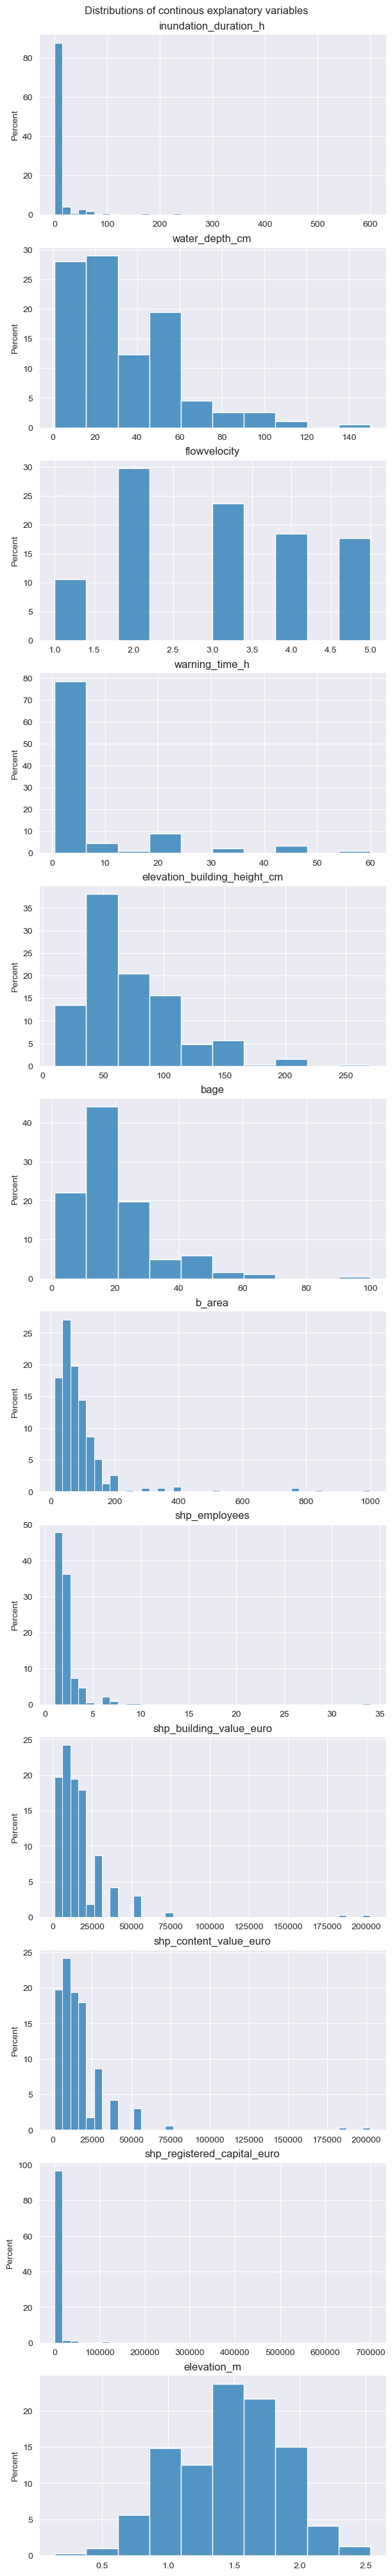

In [30]:
## plot as percantage do to different case numbers between the features (e.g registered capitals has fewer case numbers than inundation duration) 

plt.figure(figsize=(58, 28))

fig, (ax_hist) = plt.subplots(len(df_continous.columns), 1, sharex=False, figsize=(6, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig, (ax_hist) = plt.subplots(len(df_continous.columns), 2, sharex=False, figsize=(15, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of continous explanatory variables')

for i, c in enumerate(df_continous.columns[:]):
    
    df_continous_t = df_continous[c][df_continous[c]>0.0]

    #plt.subplots_adjust(hspace=.2)
    #sns.boxplot(x=df_continous[c].astype(float), ax=ax_hist[i]).set(title=f"{c}", xlabel=None)
    #sns.displot(x=df_continous[c].astype(float), binwidth=3, ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"
    if c in ["inundation_duration_h", "b_area", "shp_employees",
            "shp_building_value_euro", "shp_content_value_euro",
            "shp_registered_capital_euro" ]:
        sns.histplot(x=df_continous_t, bins=40,stat='percent', ax=ax_hist[i]).set(title=f"{c}", xlabel=None) # stat="percent"
        #ax_hist[i].semilogx("log")
        #ax_hist[i].set_xlim(0, 100000)
        #log_scale=True- dont use due that it shifts visual distrib, shrinknumber = Scale the width of each bar relative to the binwidth by this factor.
    else:
        sns.histplot(x=df_continous_t, bins=10, stat='percent', ax=ax_hist[i]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"
        #sns.histplot(x=df_continous[c].astype(float), binwidth=3, stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


In [31]:
def plot_boxplot_histogram(df):
    """
    todo make first multi plot -> than apply for only column
    df:

    return: combined boxplot and histograms 
    """
    fig, (ax_hist) = plt.subplots(len(df.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    fig.suptitle('Distributions of predicted variables')
    plt.xlim(0, 15)
    for i, c in enumerate(df_candidates_Y.columns[:]):
        ax_hist[i,1].set_xlim(0,22)  # limit histoplot
        sns.boxplot(x=df[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
        sns.histplot( x=df[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
        #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,


    # fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    # #f ig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
    # fig.suptitle(f'Distributions of {df_targets.columns}')

    # for i, c in enumerate(df_targets.columns[:]):
    #     #plt.subplots_adjust(hspace=.2)
    #     sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    #     sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


plot_boxplot_histogram(df=df_targets)

## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


NameError: name 'df_targets' is not defined

#### Target distributions


In [40]:
t = df_candidates_y.Target_contentloss_euro[df_candidates_y.Target_contentloss_euro >= 2000]#.describe()
t.describe()


count        12.000000
mean      26883.583333
std       62948.222904
min        2615.600000
25%        3640.375000
50%        3926.200000
75%       14059.425000
max      224190.400000
Name: Target_contentloss_euro, dtype: float64

<Figure size 1000x2800 with 0 Axes>

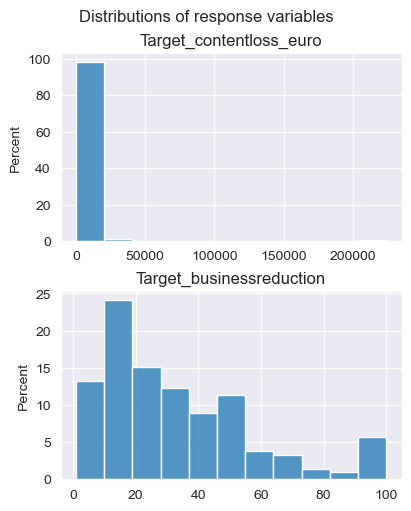

In [42]:

plt.figure(figsize=(10, 28))
#plt.figure(figsize=(10, 28))

#def pie_charts():
fig, (ax_hist) = plt.subplots(len(df_candidates_y.columns), 1, sharex=False, figsize=(4, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle('Distributions of response variables')

for i, c in enumerate(df_candidates_y.columns[:]):
    df_candidates_t = df_candidates_y[c][df_candidates_y[c]>0.0]

    # ax_hist[i].set_xlim(0,2000)  # limit histoplot
    # sns.histplot(x=df_candidates_t, stat='percent', bins=2000, ax=ax_hist[i]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"
    sns.histplot(x=df_candidates_t, stat='percent', bins=11, ax=ax_hist[i]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"
    #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,



In [ ]:
busin_direct_closses = df_candidates_y.business_reduction[df_candidates_y.business_reduction >=0.1]

#df_candidates_y.business_reduction.isna().sum()
print(df_candidates_y.Target_direct.isna().sum(), "Businesses didnt provide information")
print(df_candidates_y.Target_direct[df_candidates_y.Target_direct <=0.1].count(), "Business had no content losses")
print(df_candidates_y.Target_direct[df_candidates_y.Target_direct >=100.0].count(), "Business had content loss higher than 100 mVND")

4 Businesses didnt provide information
251 Business had no content losses
7 Business had content loss higher than 100 mVND


[Text(0.5, 1.0, 'reduce in monthly sale and production'),
 Text(0, 0.5, 'number businesses'),
 Text(0.5, 0, 'monthly reduction [%/month]')]

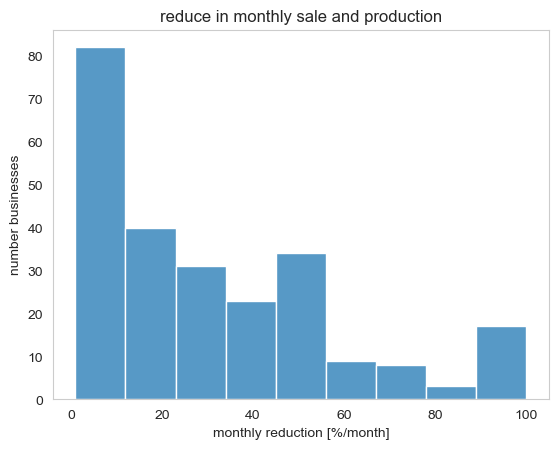

In [ ]:

fig, ax = plt.subplots()
#ax.set_ylim(0,1200)
#sns.boxplot(x=busin_direct_closses, showfliers=True).set(title=f"{c}", xlabel=None)
sns.histplot(data=busin_direct_closses, stat='count').set(title=f"reduce in monthly sale and production", ylabel="number businesses", xlabel="monthly reduction [%/month]") #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
#ax.set_xlim(0,100)


## Explore variable interactions

- PLOT Distrib -  Target_r, Target_s  with removed dublicated cases	
- PLOT Distrb+ anteil an precaution meausres == nan++not impl --> check einfluss auf damage costs in VIF/pearson -beide wichtigsten VARs impl in bivariate func
- PLOT distrib plot shop_damage_levels (funriture, electronic, spec equipment, products)


#### precautionary measures ~ content losses  (~ contamination)

Which precautionary measures reduce content losses? 
- e.g are structural implentations are really as useful for flood protection as seen in other studies eg. Harish et al 2023

Limitated content loss up to 300 euros


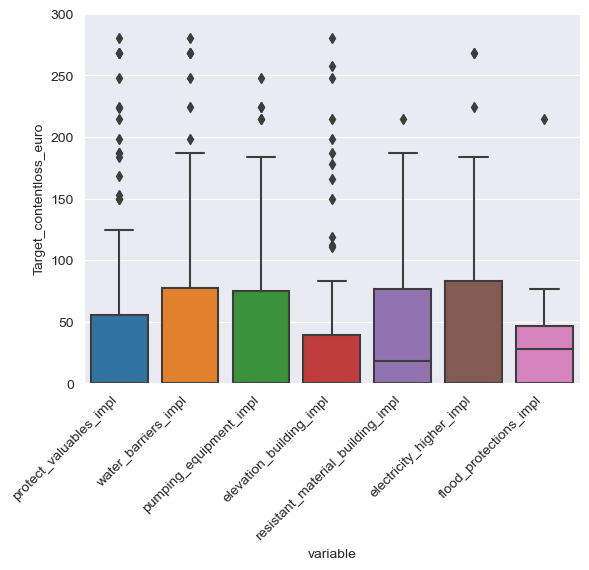

In [238]:
precaution = df_candidates.filter(regex="_impl",axis=1)
precaution_contentloss = pd.concat([precaution, df_candidates.Target_contentloss_euro], axis=1)

precaution_contentloss = precaution_contentloss.melt(id_vars="Target_contentloss_euro", value_vars=precaution)
precaution_contentloss = precaution_contentloss.loc[ precaution_contentloss.value.isin([1,2]), :]
# 1:"implemented", 2:"implemented"
precaution_contentloss

sns.boxplot(x=precaution_contentloss.variable, y=precaution_contentloss.Target_contentloss_euro)#.set(title=f"{c}", xlabel=None)
plt.ylim(0, 300)    
plt.xticks(rotation=45, ha='right')

print("Limitated content loss up to 300 euros")

In [ ]:
## frequnecy of implemented measures before the flood
precaution_contentloss = pd.concat([precaution, df_candidates.Target_contentloss_euro], axis=1).melt(id_vars="Target_contentloss_euro", value_vars=precaution)
precaution_contentloss.loc[ precaution_contentloss.value.isin([4,5]), :]
(precaution.flood_protections_impl.isin([1,2])).sum()  # count "True"

#### business sector ~ content losses  and #### business sector ~ business reduction 

#### water depth ~ emergency measures ~ content losses

Based on Kreibich 2007:
emergency measures are usefull: „Successfully saving the equipment led to a significant average reduction of damage to equipment by 28%. It is difficult to make generalizations about the positive effects of emergency measures, since they depend on the intensity of the flood event. However, the ICPR [2002] presumes a 50– 75% reduction of damage due to emergency measures in industry and trad“ ([Kreibich et al., 2007, p. 10](zotero://select/groups/5068951/items/ED3ZYW5K)) ([pdf](zotero://open-pdf/groups/5068951/items/ZHEID2CU?page=10))


*Plot binary bars*: not/sucessfully undertaken emergency measures ~ in relation to waterdepth/indundation AND/OR wanring time 
	(bc strength of flood influences effectiv emerngecy) (Kreibich 2007)


(-0.3, 24.0)

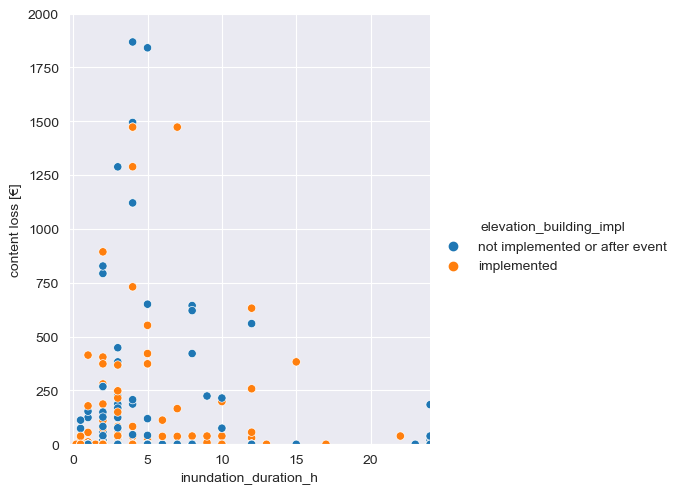

In [284]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

df_candidates["emergency_measures.9"] = df_candidates["emergency_measures.9"].replace({0:"applied", 1: "not applied"}) 
df_candidates.elevation_building_impl = df_candidates.elevation_building_impl.replace({1:"implemented", 2:"implemented", 4:"not implemented or after event", 5:"not implemented or after event"})  
# 1- impl before, 5 - didnt impl or after event

#print(df_candidates["emergency_measures.9"].value_counts())  

# dont use x=warning_time_h due to many missing values (only 89 cases have warning type)

plot_scatterplot_3d(df_candidates, x="inundation_duration_h", 
                    y="Target_contentloss_euro", 
                    z="elevation_building_impl"
                    )
plt.ylabel("content loss [€]")
plt.ylim(-0.3, 2000)
plt.xlim(-0.3, 24)




#### warning time ~ Target

Is a shorter wanring time increasing the content losses?

NameError: name 'df_candidates_Y' is not defined

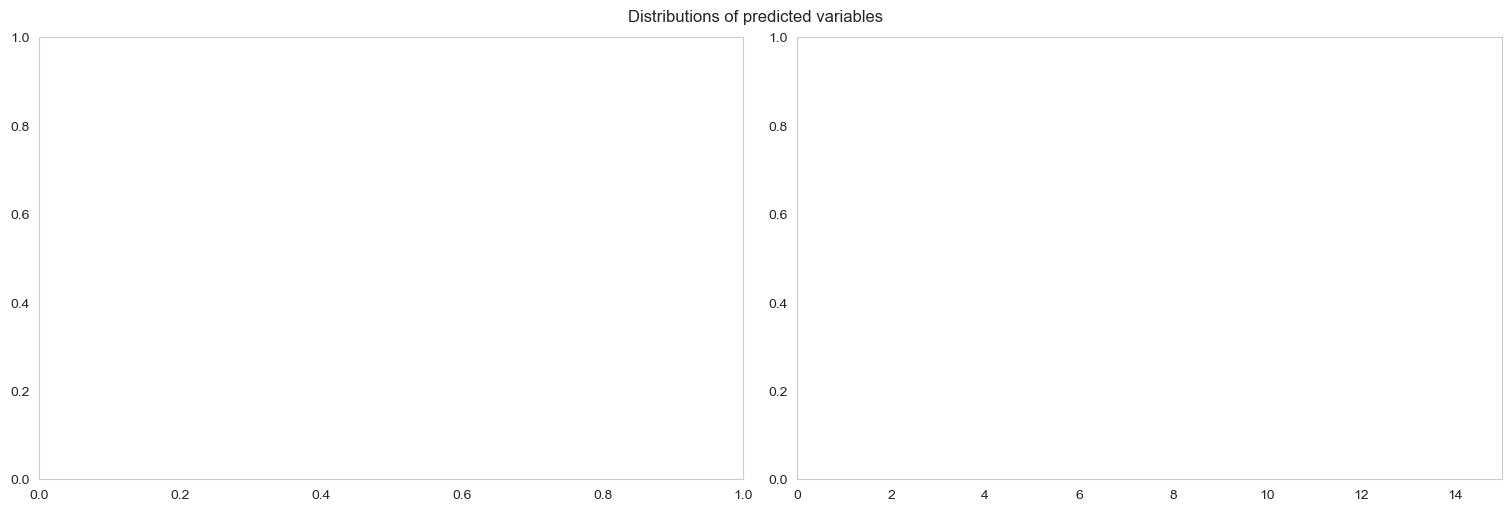

In [ ]:
def plot_boxplot_histogram(df):
    """
    todo make first multi plot -> than apply for only column
    df:

    return: combined boxplot and histograms 
    """
    fig, (ax_hist) = plt.subplots(len(df.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    fig.suptitle('Distributions of predicted variables')
    plt.xlim(0, 15)
    for i, c in enumerate(df_candidates_Y.columns[:]):
        ax_hist[i,1].set_xlim(0,22)  # limit histoplot
        sns.boxplot(x=df[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
        sns.histplot( x=df[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
        #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,


    # fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    # #f ig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
    # fig.suptitle(f'Distributions of {df_targets.columns}')

    # for i, c in enumerate(df_targets.columns[:]):
    #     #plt.subplots_adjust(hspace=.2)
    #     sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    #     sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


plot_boxplot_histogram(df=df_targets)

## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


#### contamination types 


39  businesses reported that they had no  contaminated water


Text(0.5, 1.0, 'Contamination types: \nContamination with fuel oil occures 13 times')

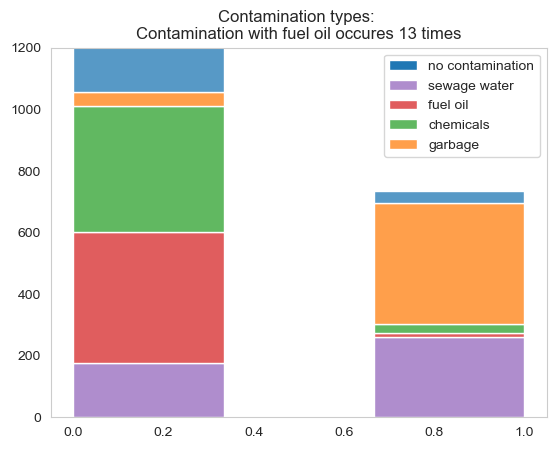

In [379]:
fig, ax = plt.subplots()
d = df_candidates.filter(regex="contamination",axis=1)
#d = d.drop(["contaminations.99", "contaminations.88"], axis=1)
sns.histplot(bins=3, data=d, multiple="stack")
#d = d.replace(r'^,', '0.', regex=True) 
#d = d.replace(',', '.') 
#sns.histplot(data=d)

#ax.set_yscale('log')
ax.set_ylim(0,1200)
ax.set_ylabel("")
ax.legend(['no contamination', 'sewage water', 'fuel oil', 'chemicals', 'garbage'], loc="best")

print(df_candidates["contaminations.0"].value_counts()[1], " businesses reported that they had no  contaminated water")
ax.set_title(f"Contamination types: \nContamination with fuel oil occures {df_candidates['contaminations.3'].value_counts()[1]} times")


In [292]:
contamination_types

,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,freq
0,0,1,0,0,1,230
1,0,1,0,0,0,130
2,1,0,0,0,0,39
3,0,1,1,0,1,17
4,0,1,1,1,1,7
5,0,0,0,0,1,5
6,0,1,1,0,0,3
7,0,1,0,1,0,2
8,0,1,0,1,1,2
9,0,1,1,1,0,2


In [50]:
contamination_types = df_candidates.filter(regex="^contamination", axis=1)#shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
contamination_types = contamination_types.value_counts().reset_index(name='freq')
#contamination_types["contamination_type"] = contamination_types#.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])
print(df_candidates["contaminations.0"].value_counts()[1], " businesses reported that they had no contaminated water")


# shop_types = df.shp_sector[df['shp_sector'] < 20]
# #shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
# shop_types = shop_types.value_counts().reset_index(name='shop_freq')
# shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

# plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
# plt.legend(shop_types.shop_type, loc="best")
# plt.title("business sectors for shops")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()


# plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
# plt.legend(shop_types.shop_type, loc="best")
# plt.title("business sectors for shops")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

df_candidates


39  businesses reported that they had no  contaminated water


,Target_direct,business_reduction,flood_time,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.5,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house.1,overall_problem_house.2,overall_problem_house.3,overall_problem_house.4,overall_problem_house.5,overall_problem_house.6,overall_problem_house.7,overall_problem_house.8,overall_problem_house.9,same,protect_valuables_impl,water_barries_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,rloss,bloss,lu_cert,building_value,building_area,bage,bage_ren,shp_closed_d,household_inhabitants_number,people_com,household_education,poverty_cert,household_monthly_income_mVND,shp_sector,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increasing,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_who_responsible4protection.Rank3,perception_who_responsible4protection.Rank4,perception_who_responsible4protection.Rank5,perception_who_responsible4protection.Rank6,perception_who_responsible4protection.Rank7,perception_who_responsible4protection.Rank88,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,id,elevation_m,lon,lat,geometry
0,0.0,10.0,2020-09-01,1.0,50.0,0,1,0,0,0,3,NaN,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,False,4.0,5.0,5.0,1.0,5.0,1.0,5.0,6,0.000000,0.0,1.0,800.0,156.0,45.0,45.0,0.0,8,1,4.0,0,3.0,11,5.0,3.0,2.0,4.0,1.0,3,4.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,3.0,0.0,1.40,10.724409,106.602300,POINT (106.60230 10.72441)
1,4.0,5.0,2016-12-01,1.0,10.0,0,1,0,0,1,2,NaN,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5,1.000000,600000000.0,1.0,600.0,118.0,18.0,18.0,2.0,4,0,5.0,0,4.0,17,2.0,1.0,1.0,1.0,1.0,5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.61,10.733775,106.608990,POINT (106.60899 10.73377)
2,0.0,0.0,2013-10-01,1.0,30.0,0,1,0,0,1,3,NaN,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.108333,65000000.0,1.0,600.0,114.0,1.0,1.0,1.0,5,0,4.0,0,4.0,13,1.0,2.0,1.0,2.0,2.0,4,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,2.0,1.47,10.824286,106.733150,POINT (106.73315 10.82429)
3,0.0,NaN,2020-08-15,1.0,1.0,0,1,0,0,0,1,1.0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,1.0,5.0,5.0,1.0,5.0,5.0,5.0,3,0.000000,0.0,1.0,4000.0,27.0,6.0,3.0,0.0,3,0,4.0,1,3.0,11,2.0,5.0,1.0,1.0,3.0,5,3.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,3.0,1.09,10.726964,106.629986,POINT (106.62999 10.72696)
4,10.0,35.0,2020-08-01,1.0,30.0,0,0,0,0,1,2,NaN,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,False,1.0,5.0,5.0,1.0,5.0,1.0,5.0,5,0.012500,10000000.0,1.0,800.0,350.0,18.0,8.0,2.0,4,0,5.0,0,3.0,17,5.0,NaN,5.0,5.0,NaN,5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.10,10.721289,106.632836,POINT (106.63284 10.72129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.0,0.0,2019-09-01,0.5,10.0,1,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,False,1.0,1.0,5.0,1.0,5.0,1.0,5.0,5,0.000000,0.0,1.0,200.0,70.0,14.0,2.0,0.0,5,0,5.0,0,2.0,22,2.0,2.0,2.0,2.0,3.0,5,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,247.0,1.95,10.705101,106.688031,POINT (106.68803 10.70510)
438,1.0,10.0,2020-08-06,0.5,10.0,0,1,0,0,0,2,NaN,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,5.0,5.0,5.0,1.0,5.0,5.0,5.0,1,0.000000,0.0,1.0,500.0,35.0,45.0,45.0,2.0,4,0,8

#### Contamination vs water depth

In [210]:
contamination_types = df_candidates.filter(regex="^contamination", axis=1)


df_conta_wd = pd.concat([contamination_types, df_candidates.water_depth_cm], axis=1)
df_conta_wd.head(2)#.contaminations.value_counts()
df_conta_wd = df_conta_wd.melt(id_vars=['water_depth_cm'], value_vars=['contaminations.0', 'contaminations.1', 'contaminations.2', 'contaminations.3', 'contaminations.4'])
df_conta_wd = df_conta_wd.loc[df_conta_wd.value==1,:]
df_conta_wd#.water_depth_cm.value_counts()
#df_conta_wd["variable"] = 
df_conta_wd["variable"].replace({'contaminations.0':'had no contamination', 
             'contaminations.1':'sewage water', 
             'contaminations.2':'fuel oil', 
             'contaminations.3':'chemicals', 
             'contaminations.4':'garbage'},  inplace=True)


df_conta_wd = df_conta_wd.loc[df_conta_wd.water_depth_cm <= 100, :] 
df_conta_wd.shape


# sns.boxplot(x="inundation_duration_h", y= "variable", data=df_conta_wd).set(title=f"contamination types", xlabel=None) # ax=ax_hist[i, 0]
# ax.set_xlabel("inundation_duration_h")


(641, 3)

In [211]:
df_conta_wd

,water_depth_cm,variable,value
0,10.0,had no contamination,1
2,2.0,had no contamination,1
3,10.0,had no contamination,1
5,3.0,had no contamination,1
9,20.0,had no contamination,1
...,...,...,...
1978,60.0,garbage,1
1979,40.0,garbage,1
1982,70.0,garbage,1
1983,70.0,garbage,1


without the frequecny of each contamination type, it seems that chemicals
 occure with lightly higher water depths but they occure just 10 times
 - this is to less for a foundated assessment


variable
sewage water            350
garbage                 219
had no contamination     35
fuel oil                 27
chemicals                10
Name: count, dtype: int64

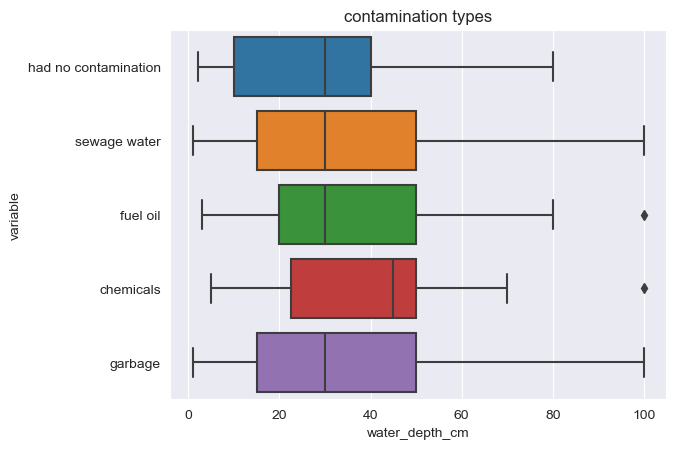

In [212]:
fig, ax = plt.subplots()

sns.boxplot(x="water_depth_cm", y= "variable", data=df_conta_wd).set(title=f"contamination types", xlabel=None) # ax=ax_hist[i, 0]
ax.set_xlabel("water_depth_cm")
print("without the frequecny of each contamination type, it seems that chemicals\n occure with lightly higher water depths but they occure just 10 times\n - this is to less for a foundated assessment")
#ax.set_xlim(0,200)
#x="variable", y="value", data=pd.melt(df))
# sns.boxplot(data=df, x="age", y="class")
df_conta_wd.variable.value_counts()

#### business types 
grouped by their parent sector


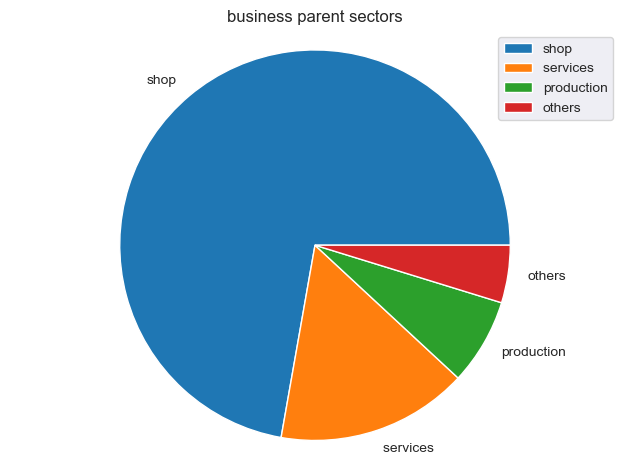

In [ ]:
bins =  np.arange(10, 90, 10)  # business sectors
ind = np.digitize(df['shp_sector'], bins)
 
shp_sectors = df.shp_sector.groupby(ind).value_counts().reset_index(name='sector_freq')
shp_sectors = shp_sectors.groupby("level_0")['sector_freq'].sum().reset_index()
#shp_sectors.shp_sector = shp_sectors.shp_sector.replace([11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 31, 32, 33, 34, 35, 88],["food","fashion", "houseware"])

shp_sectors["sectors"] = shp_sectors.level_0.replace([1, 2, 3, 8],["shop", "services ", "production", "others"])

plt.pie(x="sector_freq", labels="sectors", data=shp_sectors)
plt.legend(shp_sectors.sectors, loc="best")
plt.title("business sectors")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### business types of shops

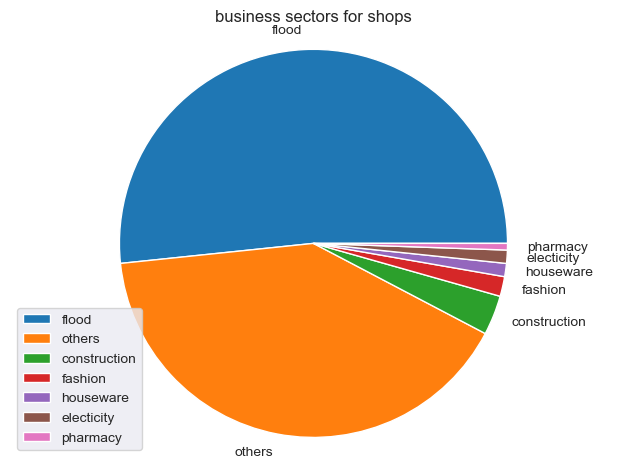

In [ ]:
shop_types = df.shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
shop_types = shop_types.value_counts().reset_index(name='shop_freq')
shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
plt.legend(shop_types.shop_type, loc="best")
plt.title("business sectors for shops")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Statistics of variable distributions
mean, SD, amount of NAN

In [594]:
df_stats =pd.DataFrame(index=df_candidates.columns)

for c in df_candidates.columns.drop(["flood_time", "lat", "lon", "geometry"]):
    df_stats.loc[c, "min"] = df_candidates[c].min()
    df_stats.loc[c, "max"] = df_candidates[c].max()
    df_stats.loc[c, "mean"] = df_candidates[c].mean()#.round(2)
    df_stats.loc[c, "median"] = df_candidates[c].median()
    df_stats.loc[c, "sd"] = df_candidates[c].std()#.round(2)
    df_stats.loc[c, "no_value"] = df_candidates[c].isin([0, 99]).sum() | df_candidates[c].isna().sum()

print(df_stats.head(30))    


                         min     max       mean  median          sd  no_value
Target_direct            0.0  6000.0  36.630822     0.0  408.423207     255.0
business_reduction       0.0   100.0  19.624691    10.0   25.770260     191.0
flood_time               NaN     NaN        NaN     NaN         NaN       NaN
inundation_duration_h    0.2   600.0  13.156351     3.0   40.915054       9.0
water_depth_cm           1.0   150.0  35.315193    30.0   26.139190       1.0
contaminations.0         0.0     1.0   0.088235     0.0    0.283958     403.0
contaminations.1         0.0     1.0   0.895928     1.0    0.305700      46.0
contaminations.2         0.0     1.0   0.070136     0.0    0.255665     411.0
contaminations.3         0.0     1.0   0.029412     0.0    0.169149     429.0
contaminations.4         0.0     1.0   0.599548     1.0    0.490545     177.0
flowvelocity             1.0     5.0   3.022624     3.0    1.279326       0.0
warning_time_h           0.5    60.0   7.870000     1.0   13.962

c:\Anaconda\envs\py396_c3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Summarize quantitative exploration of variable distribtuions
--> warning_time_h and elevation rel2surounding have more than 200 entires missing (total 252 obs), therefore these variabels should be combined with other variables to a new variable (PCA) or should be excluded from feature space